**Data Preprocessing**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Load the uploaded dataset to inspect its structure
import pandas as pd

# Path ke file dalam Google Drive
file_path = 'arramooz-master/verbs_with_madhi_mudhori_amar.csv'

# Baca file CSV
data = pd.read_csv(file_path)
print(data.head())

   ID Unvocalized    Vocalized Root  Triliteral        Madhi      Mudhori  \
0   1        أمكن      أمْكَنَ  مكن           0     أَمْكَنَ     يُمْكِنُ   
1   2      استحال  اِسْتَحَالَ  حيل           0  اِسْتَحَالَ  يَسْتَحِيلُ   
2   3         زها        زَهَا  زهو           1        زَهَا     يَزْهِوُ   
3   4         بئس       بِئْسَ  بأس           1       بَئِسَ     يَبْئِسُ   
4   5        أغمى      أَغْمَى  غمي           0      أَغْمَى      يُغْمِي   

         Amar  
0    أَمْكِنْ  
1  اِسْتَحِلْ  
2      اِزْهِ  
3    اِبْئِسْ  
4      أَغْمِ  


In [2]:
# Display the first few rows of the dataset to understand its structure
data.head()

# Check for missing values
print("Missing values in each column:")
print(data.isnull().sum())

# Ensure the data is in the correct format
print("\nData types of each column:")
print(data.dtypes)

# Display the first few rows of the updated DataFrame
print("\nFirst few rows of the DataFrame:")
print(data.head())

Missing values in each column:
ID             0
Unvocalized    0
Vocalized      0
Root           0
Triliteral     0
Madhi          0
Mudhori        0
Amar           0
dtype: int64

Data types of each column:
ID              int64
Unvocalized    object
Vocalized      object
Root           object
Triliteral      int64
Madhi          object
Mudhori        object
Amar           object
dtype: object

First few rows of the DataFrame:
   ID Unvocalized    Vocalized Root  Triliteral        Madhi      Mudhori  \
0   1        أمكن      أمْكَنَ  مكن           0     أَمْكَنَ     يُمْكِنُ   
1   2      استحال  اِسْتَحَالَ  حيل           0  اِسْتَحَالَ  يَسْتَحِيلُ   
2   3         زها        زَهَا  زهو           1        زَهَا     يَزْهِوُ   
3   4         بئس       بِئْسَ  بأس           1       بَئِسَ     يَبْئِسُ   
4   5        أغمى      أَغْمَى  غمي           0      أَغْمَى      يُغْمِي   

         Amar  
0    أَمْكِنْ  
1  اِسْتَحِلْ  
2      اِزْهِ  
3    اِبْئِسْ  
4      أَغْمِ  


**Model Architecture and Training**

In [5]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load dataset
data = pd.read_csv('arramooz-master/verbs_with_madhi_mudhori_amar.csv')

# Select relevant columns
input_column = 'Unvocalized'
output_columns = ['Madhi', 'Mudhori', 'Amar']

# Drop rows with missing values
data = data.dropna(subset=[input_column] + output_columns)

# Simplify rare classes by grouping them into 'Other'
threshold = 3
for col in output_columns:
    value_counts = data[col].value_counts()
    rare_classes = value_counts[value_counts < threshold].index
    data[col] = data[col].apply(lambda x: 'Other' if x in rare_classes else x)

# Tokenizer setup
max_vocab_size = 3000
max_sequence_length = 6
tokenizer = Tokenizer(num_words=max_vocab_size, char_level=True, oov_token='<UNK>')
tokenizer.fit_on_texts(data[input_column])

# Convert text to sequences and pad them
X = tokenizer.texts_to_sequences(data[input_column])
X = pad_sequences(X, maxlen=max_sequence_length, padding='post')

# Encode target columns
label_encoders = {}
y_encoded = {}
for col in output_columns:
    le = LabelEncoder()
    y_encoded[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Stack encoded target columns
y = np.stack([y_encoded[col] for col in output_columns], axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Model architecture
def create_model(max_vocab_size, max_sequence_length, output_dims):
    input_layer = Input(shape=(max_sequence_length,))
    embedding_layer = Embedding(
        input_dim=max_vocab_size,
        output_dim=64,
        input_length=max_sequence_length,
        embeddings_regularizer=l2(1e-4)
    )(input_layer)
    norm_layer = BatchNormalization()(embedding_layer)
    lstm_layer = Bidirectional(LSTM(
        128,
        return_sequences=True,
        kernel_regularizer=l2(1e-4),
        recurrent_regularizer=l2(1e-4),
        bias_regularizer=l2(1e-4)
    ))(norm_layer)
    lstm_layer = Dropout(0.4)(lstm_layer)
    lstm_layer = BatchNormalization()(lstm_layer)
    lstm_layer = Bidirectional(LSTM(
        128,
        return_sequences=False,
        kernel_regularizer=l2(1e-4),
        recurrent_regularizer=l2(1e-4),
        bias_regularizer=l2(1e-4)
    ))(lstm_layer)
    lstm_layer = Dropout(0.4)(lstm_layer)
    dense_layer = BatchNormalization()(lstm_layer)
    output_layers = []
    for i, dim in enumerate(output_dims):
        output = Dense(
            dim,
            activation='softmax',
            name=output_columns[i],
            kernel_regularizer=l2(1e-4)
        )(dense_layer)
        output_layers.append(output)
    return Model(inputs=input_layer, outputs=output_layers)

# Number of classes for each output
output_dims = [len(label_encoders[col].classes_) for col in output_columns]

# Create and compile model
model = create_model(max_vocab_size, max_sequence_length, output_dims)
model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss=['sparse_categorical_crossentropy'] * len(output_columns),
    metrics=['accuracy'] * len(output_columns)
)

#Display Model
model.summary()

# Callbacks for training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train,
    [y_train[:, i] for i in range(y_train.shape[1])],
    validation_data=(X_test, [y_test[:, i] for i in range(y_test.shape[1])]),
    epochs=50,
    batch_size=64,
    callbacks=[ reduce_lr],
    verbose=1
)

c:\Users\dzak\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 6, 64)     │    192,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 64)     │        256 │ embedding_1[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 6, 256)    │    197,632 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 6, 256)    │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 256)    │      1,024 │ dropout_2[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 256)       │    394,240 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dropout_3[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Madhi (Dense)       │ (None, 110)       │     28,270 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Mudhori (Dense)     │ (None, 321)       │     82,497 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Amar (Dense)        │ (None, 391)       │    100,487 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 997,430 (3.80 MB)

 Trainable params: 996,278 (3.80 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - Amar_accuracy: 0.2604 - Amar_loss: 5.8416 - Madhi_accuracy: 0.1861 - Madhi_loss: 4.8426 - Mudhori_accuracy: 0.2655 - Mudhori_loss: 5.7215 - loss: 16.6735 - val_Amar_accuracy: 0.8750 - val_Amar_loss: 3.1069 - val_Madhi_accuracy: 0.9685 - val_Madhi_loss: 2.1171 - val_Mudhori_accuracy: 0.8980 - val_Mudhori_loss: 3.1240 - val_loss: 8.5824 - learning_rate: 5.0000e-04
Epoch 2/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - Amar_accuracy: 0.7148 - Amar_loss: 3.6799 - Madhi_accuracy: 0.8315 - Madhi_loss: 2.1349 - Mudhori_accuracy: 0.7326 - Mudhori_loss: 3.6175 - loss: 9.6784 - val_Amar_accuracy: 0.8750 - val_Amar_loss: 1.1428 - val_Madhi_accuracy: 0.9685 - val_Madhi_loss: 0.3164 - val_Mudhori_accuracy: 0.8980 - val_Mudhori_loss: 0.9774 - val_loss: 2.6601 - learning_rate: 5.0000e-04
Epoch 3/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - Amar_accuracy: 0.8526 - Amar_loss: 1.3777 - Madhi_accuracy: 0.9600 - Madhi_loss: 0.4352 - Mudhori_accura

**Evaluate the Model**

In [6]:
evaluation = model.evaluate(
    X_test, [y_test[:, i] for i in range(y_test.shape[1])], verbose=1
)

print("Evaluation Results:")
for col, index in zip(output_columns, [6, 5, 4]):  # Indeks untuk Madhi, Mudhari, Amar
    print(f"{col} Accuracy: {evaluation[index] * 100:.2f}%")



67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - Amar_accuracy: 0.9414 - Amar_loss: 0.3316 - Madhi_accuracy: 0.9798 - Madhi_loss: 0.1257 - Mudhori_accuracy: 0.9599 - Mudhori_loss: 0.2717 - loss: 0.9948
Evaluation Results:
Madhi Accuracy: 96.43%
Mudhori Accuracy: 98.45%
Amar Accuracy: 94.78%


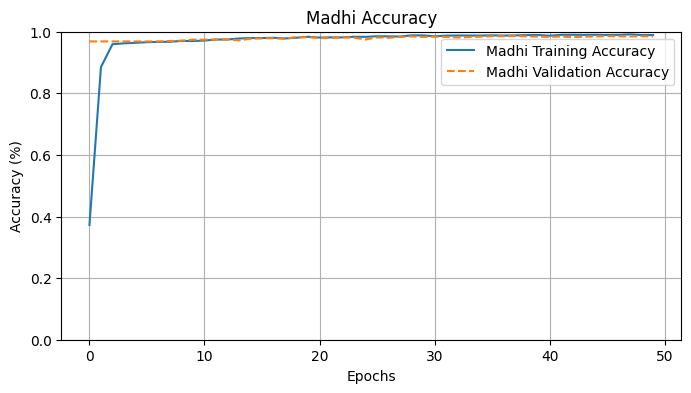

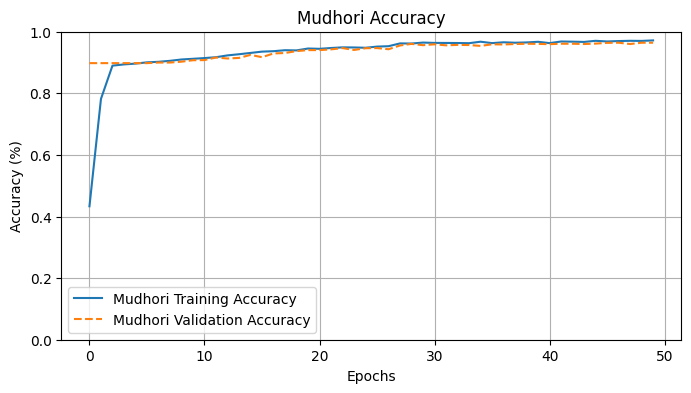

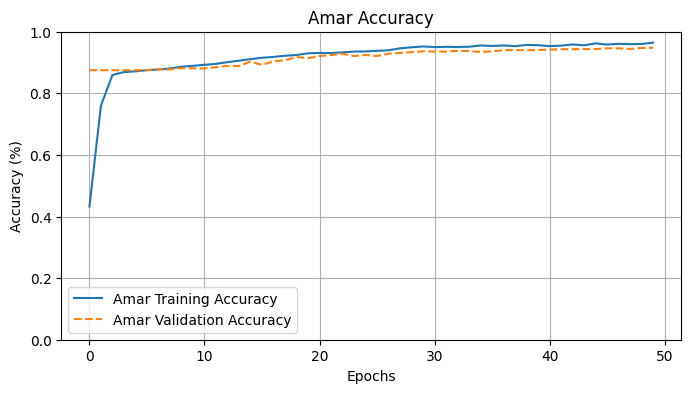

In [7]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy for each output
def plot_training_accuracy(history, output_columns):
    for col in output_columns:
        plt.figure(figsize=(8, 4))
        # Plot training and validation accuracy
        plt.plot(history.history[f'{col}_accuracy'], label=f'{col} Training Accuracy')
        plt.plot(history.history[f'val_{col}_accuracy'], label=f'{col} Validation Accuracy', linestyle='--')
        plt.title(f'{col} Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.show()

# Call the function to plot accuracy
plot_training_accuracy(history, output_columns)


**Save, Load, and Test Model**

In [ ]:


while True:  # Loop untuk mengizinkan pengujian berulang kali
   
    test_word = input("Masukkan kata untuk pengujian (atau ketik 'exit' untuk keluar): ").strip()
    if test_word.lower() == 'exit':  # Keluar dari loop jika pengguna mengetik 'exit'
        print("Keluar dari pengujian.")
        break

    # Preprocessing: Tokenize dan pad input
    test_sequence = tokenizer.texts_to_sequences([test_word])
    test_sequence = pad_sequences(test_sequence, maxlen=max_sequence_length, padding='post')

    # Prediksi menggunakan model
    predictions = model.predict(test_sequence)

    # Decode hasil prediksi untuk setiap output
    decoded_outputs = {}
    for i, col in enumerate(output_columns):
        predicted_class = np.argmax(predictions[i], axis=-1)  # Ambil kelas dengan probabilitas tertinggi
        decoded_outputs[col] = label_encoders[col].inverse_transform([predicted_class[0]])[0]  # Dekode ke label asli

    # Tampilkan hasil prediksi
    print(f"\nHasil Prediksi untuk kata '{test_word}':")
    for col, result in decoded_outputs.items():
        print(f"{col}: {result}")
    print("-" * 30)  # Pemisah untuk setiap pengujian


In [8]:
# Save the trained model
model.save('arabic_verb_model.h5')
print("Model berhasil disimpan sebagai 'arabic_verb_model.h5'")

Model berhasil disimpan sebagai 'arabic_verb_model.h5'


In [14]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the saved model
print("Memuat model...")
model = load_model('arabic_verb_model.h5')
print("Model berhasil dimuat.")



   
test_word = 'فعل'.strip()
if test_word.lower() == 'exit':  # Keluar dari loop jika pengguna mengetik 'exit'
    print("Keluar dari pengujian.")

    # Preprocessing: Tokenize dan pad input
test_sequence = tokenizer.texts_to_sequences([test_word])
test_sequence = pad_sequences(test_sequence, maxlen=max_sequence_length, padding='post')

    # Prediksi menggunakan model
predictions = model.predict(test_sequence)

    # Decode hasil prediksi untuk setiap output
decoded_outputs = {}
for i, col in enumerate(output_columns):
    predicted_class = np.argmax(predictions[i], axis=-1)  # Ambil kelas dengan probabilitas tertinggi
    decoded_outputs[col] = label_encoders[col].inverse_transform([predicted_class[0]])[0]  # Dekode ke label asli

    # Tampilkan hasil prediksi
print(f"\nHasil Prediksi untuk kata '{test_word}':")
for col, result in decoded_outputs.items():
    print(f"{col}: {result}")
print("-" * 30)  # Pemisah untuk setiap pengujian


Memuat model...


Model berhasil dimuat.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Hasil Prediksi untuk kata 'فعل':
Madhi: Other
Mudhori: Other
Amar: Other
------------------------------


In [15]:
import pickle

# Save the tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the label encoders
with open('label_encoders.pickle', 'wb') as handle:
    pickle.dump(label_encoders, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
#Load the saved model
print("Memuat model...")
model = load_model('arabic_verb_model.h5')
print("Model berhasil dimuat.")

# Load the tokenizer and label encoders
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

with open('label_encoders.pickle', 'rb') as handle:
    label_encoders = pickle.load(handle)

# Define the maximum sequence length and output columns
max_sequence_length = 6
output_columns = ['Madhi', 'Mudhori', 'Amar']

while True:  # Loop untuk mengizinkan pengujian berulang kali
    test_word = input("Masukkan kata untuk pengujian (atau ketik 'exit' untuk keluar): ").strip()
    if test_word.lower() == 'exit':  # Keluar dari loop jika pengguna mengetik 'exit'
        print("Keluar dari pengujian.")
        break

    # Preprocessing: Tokenize dan pad input
    test_sequence = tokenizer.texts_to_sequences([test_word])
    test_sequence = pad_sequences(test_sequence, maxlen=max_sequence_length, padding='post')

    # Prediksi menggunakan model
    predictions = model.predict(test_sequence)

    # Decode hasil prediksi untuk setiap output
    decoded_outputs = {}
    for i, col in enumerate(output_columns):
        predicted_class = np.argmax(predictions[i], axis=-1)  # Ambil kelas dengan probabilitas tertinggi
        decoded_outputs[col] = label_encoders[col].inverse_transform([predicted_class[0]])[0]  # Dekode ke label asli

    # Tampilkan hasil prediksi
    print(f"\nHasil Prediksi untuk kata '{test_word}':")
    for col, result in decoded_outputs.items():
        print(f"{col}: {result}")
    print("-" * 30)  # Pemisah untuk setiap pengujian

Memuat model...


Model berhasil dimuat.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Hasil Prediksi untuk kata 'فعل':
Madhi: Other
Mudhori: Other
Amar: Other
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Hasil Prediksi untuk kata 'فعل':
Madhi: Other
Mudhori: Other
Amar: Other
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Hasil Prediksi untuk kata 'فعل':
Madhi: Other
Mudhori: Other
Amar: Other
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Hasil Prediksi untuk kata 'مكن':
Madhi: Other
Mudhori: Other
Amar: Other
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Hasil Prediksi untuk kata 'مكن':
Madhi: Other
Mudhori: Other
Amar: Other
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Hasil Prediksi untuk kata '':
Madhi: عَرَّ
Mudhori: يَزِرُّ
Amar: Other
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Hasil Prediksi untuk kata '':
Madhi: عَرَّ
Mudhori: يَزِرُّ
Amar: Other
-----------